# Drifter L1 Data Exploration
- plot observations spatial density for each temporal resolution
- for a given trajectory plot the drifter velocity vectors and the interpolated field vectors
- see an example of inertial oscillations

In [6]:
import os
from glob import glob

import cartopy.geodesic as geod
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.geodesic import Geodesic

import numpy as np
import xarray as xr
import pandas as pd

import jax
import jax.numpy as jnp
import jaxparrow as jpw

%matplotlib inline
from matplotlib import pyplot as plt

path_save_plot = './save_plots/save_plots_2024-06-12_DrifterL1DataExploration'
drifters_directory = '/home/bouxdecl/Documents/data/DRIFTERS'

bbox_drifters = [0, 13.5, 36.5, 44]
bbox_mediterranea = [-5.8, 36.5, 30, 44.5]

## Data selection

In [7]:
drifters_directory = '/home/bouxdecl/Documents/data/DRIFTERS/'
L1_dir = drifters_directory + '/L1'
os.listdir(L1_dir)[:5]

['L1_svp_bcg_20230509_070000_10min.csv',
 'L1_svp_ogs_20231005_140000_all.csv',
 'L1_carthe_lops_20230912_192142_5min.nc',
 'L1_svp_shom_20231005_140000_10min.csv',
 'L1_svp_ogs_20231005_140000_1h.nc']

filename convention : L1_type_source_aaaammjj_hhmmss_sampling.format

In [10]:
def file_selection_format(files, format: str):
    # format in {.csv, .nc}

    selected_files = []
    for file in files:
         if file.count(format):
            selected_files.append(file)
    return selected_files 

def file_selection_mediterranean(files):
    # only mediterranean (not containing 'uwa') 

    selected_files = []
    for file in files:
         if not file.count("uwa"):
            selected_files.append(file)
    return selected_files


def file_selection_by_sampling(files, sampling: str):
    # files from one L1 sampling: '5min', '10min', '30min', '1h'

    selected_files = []
    for file in files:
         if file.count(sampling):
            selected_files.append(file)
    return selected_files

In [11]:
mediterranea_files = file_selection_mediterranean( file_selection_format(os.listdir(L1_dir), ".nc") )

files_5min  = file_selection_by_sampling(mediterranea_files, "5min")
files_10min = file_selection_by_sampling(mediterranea_files, "10min")
files_30min = file_selection_by_sampling(mediterranea_files, "30min")
files_1h    = file_selection_by_sampling(mediterranea_files, "1h")

files_1h

['L1_svp_ogs_20231005_140000_1h.nc', 'L1_svp_scripps_20231006_120000_1h.nc']

## Spaghetti plot

#### trajectory plot for a temporal resolution :

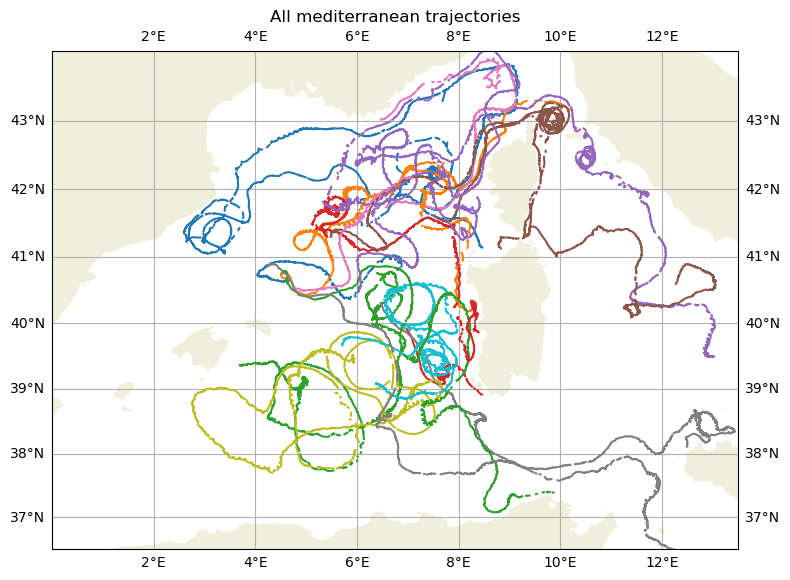

In [6]:
""" fig = plt.figure(tight_layout=True, figsize=(8, 8))
crs = ccrs.PlateCarree()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
gl = ax.gridlines(draw_labels=True,)

ax.add_feature(cfeature.LAND,)
bbox = [0,13.5, 36.5,44]
ax.set_extent(bbox)

for file in files_1h:
    ds = xr.open_dataset(os.path.join(L1_dir, file))
    for i in range(ds.sizes['id']):
        ax.plot(ds.isel(id=i).lon, ds.isel(id=i).lat,transform=crs, label=str(i))

### SAVE
ax.set_title("All 1h sampling trajectories")
save_name = 'all_1hsampling_trajectories.png'
plt.savefig(os.path.join(path_save_plot,save_name), bbox_inches='tight', dpi = 300) """

## Observations repartition

#### Spatial histogram by temporal resolution

In [6]:
def get_observation_density(data_dir, files, n_bins=100):
    # get 1D array for latitude and longitude over all observations
    all_lat, all_lon = np.array([]), np.array([])

    for file in files:
        ds = xr.open_dataset(os.path.join(data_dir, file))
        x, y = ds.lat.values.flatten(), ds.lon.values.flatten()
        all_lat = np.concatenate([all_lat, x])
        all_lon = np.concatenate([all_lon, y])

    all_lat = all_lat[~np.isnan(all_lat)]
    all_lon = all_lon[~np.isnan(all_lon)]

    # histogram 2D of the observations number
    hist, lat_edges, lon_edges = np.histogram2d(all_lat, all_lon, bins=n_bins, range=None, density=False)
    
    return hist, lat_edges, lon_edges



def plot_observation_density(hist, lat_edges, lon_edges, save_name):
    # Set up the figure and map projection
    fig = plt.figure(tight_layout=True, figsize=(8, 8))
    crs = ccrs.PlateCarree()
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
    _ = ax.gridlines(draw_labels=True,)

    # Add land feature for better visualization
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)

    # Set the map extent
    bbox = [0, 13.5, 36.5, 44]
    ax.set_extent(bbox, crs=crs)

    # Plot the density of points
    mesh = ax.pcolormesh(lon_edges, lat_edges, hist, transform=crs, cmap='Oranges')

    # Add a color bar to show the density scale
    cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_label('Density')

    ### SAVE
    ax.set_title(save_name)
    save_name = save_name
    plt.savefig(os.path.join(path_save_plot,save_name), bbox_inches='tight', dpi = 300)

In [7]:
""" files = files_5min
save_name = 'observation_density_5min'
hist, lat_edges, lon_edges = get_observation_density(L1_dir, files, n_bins=100)
plot_observation_density(hist, lat_edges, lon_edges, save_name) """

" files = files_5min\nsave_name = 'observation_density_5min'\nhist, lat_edges, lon_edges = get_observation_density(L1_dir, files, n_bins=100)\nplot_observation_density(hist, lat_edges, lon_edges, save_name) "

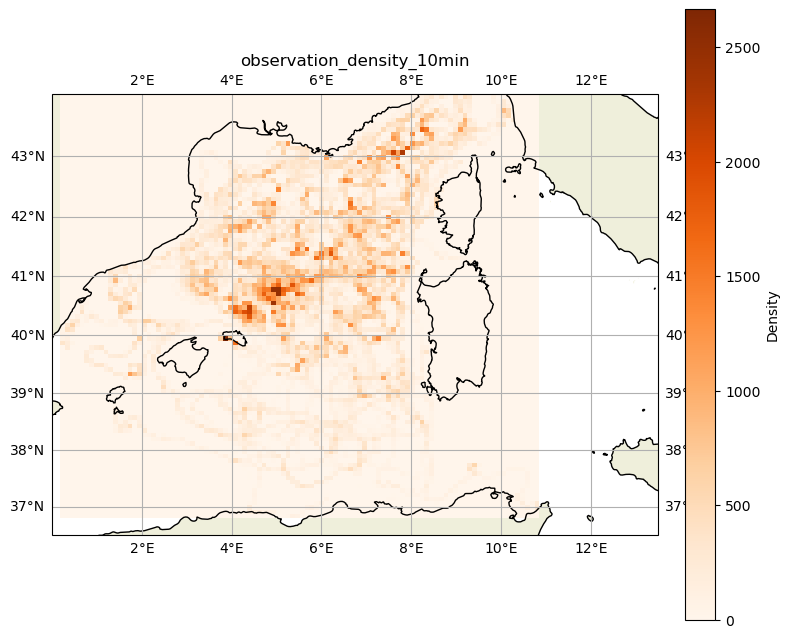

In [25]:
""" files = files_10min
save_name = 'observation_density_10min'
hist, lat_edges, lon_edges = get_observation_density(L1_dir, files, n_bins=100)
plot_observation_density(hist, lat_edges, lon_edges, save_name) """

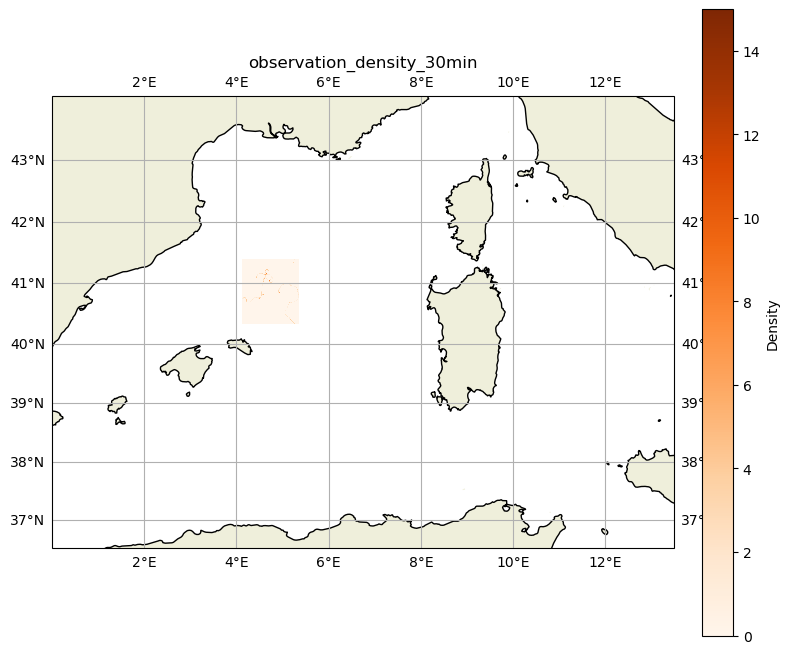

In [26]:
""" files = files_30min
save_name = 'observation_density_30min'
hist, lat_edges, lon_edges = get_observation_density(L1_dir, files, n_bins=100)
plot_observation_density(hist, lat_edges, lon_edges, save_name) """

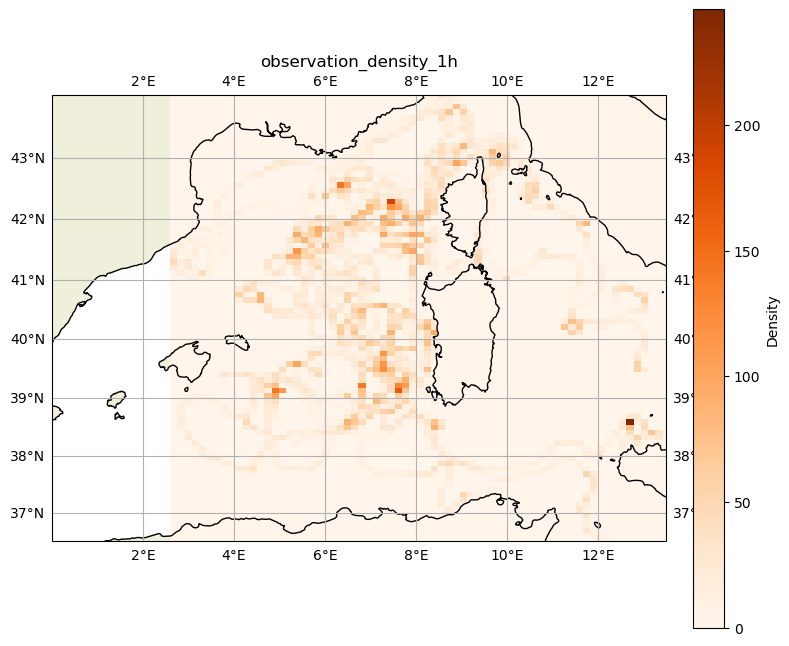

In [8]:
""" files = files_1h
save_name = 'observation_density_1h'
hist, lat_edges, lon_edges = get_observation_density(L1_dir, files, n_bins=100)
plot_observation_density(hist, lat_edges, lon_edges, save_name) """

#### Time repartition by temporal resolution

In [8]:
def get_all_observation_time(files):
    all_times   = np.array([], dtype=np.datetime64)
    start_times = np.array([], dtype=np.datetime64)
    end_times   = np.array([], dtype=np.datetime64)

    for file in files:
        ds = xr.open_dataset(os.path.join(L1_dir, file))
        time = ds.time.values.flatten()
        all_times = np.concatenate([all_times, time])
        for id in ds.id:
            times_id = ds.sel(id=id).time.values
            start_time = times_id[~np.isnan(ds.sel(id=id).velocity.values)][0]
            end_time = times_id[~np.isnan(ds.sel(id=id).velocity.values)][-1]
            start_times = np.concatenate([start_times, np.array([start_time])])
            end_times = np.concatenate([end_times, np.array([end_time])])

    return all_times[~np.isnan(all_times)], start_times, end_times


def plot_time_histogram(files, name):
    times, start_times, end_times = get_all_observation_time(files)
    hist, _, _ = plt.hist(times, bins=100, color='black')

    
    order = np.argsort(start_times)
    start_times = start_times[order]
    end_times = end_times[order]
    factor = 0.5/start_times.shape[0]  *np.max(hist)
    lw = 0.75
    plt.plot([start_times[0], end_times[0]], [1*factor, 1*factor], color='orange', lw=lw, label='life duration')
    for k in range(1, start_times.shape[0]):
        plt.plot([start_times[k], end_times[k]], [(k+1)*factor, (k+1)*factor], color='orange', lw=lw)
    plt.gcf().autofmt_xdate()
    plt.title(name)
    plt.legend()
    
    ### SAVE
    save_name = name
    plt.savefig(os.path.join(path_save_plot,save_name), bbox_inches='tight', dpi = 300)

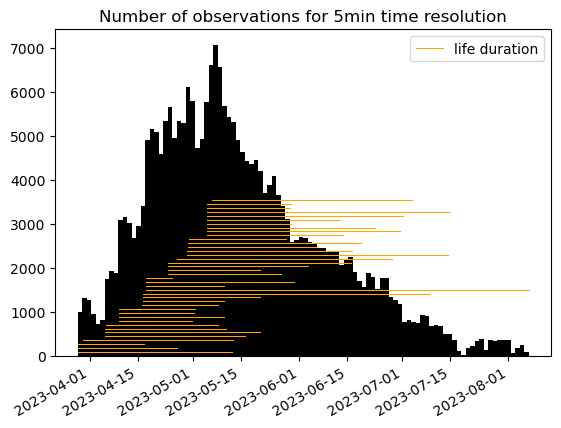

In [79]:
plot_time_histogram(files_5min, name='Number of observations for 5min time resolution')

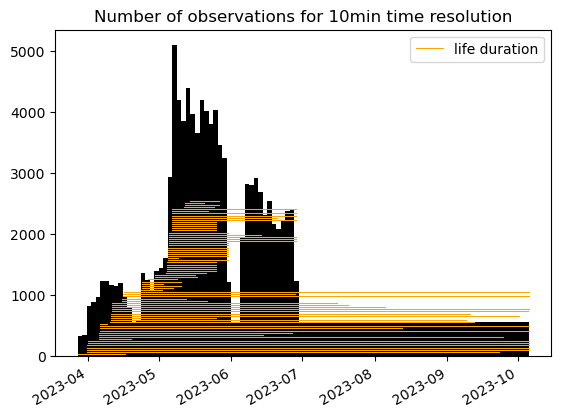

In [80]:
plot_time_histogram(files_10min, name='Number of observations for 10min time resolution')

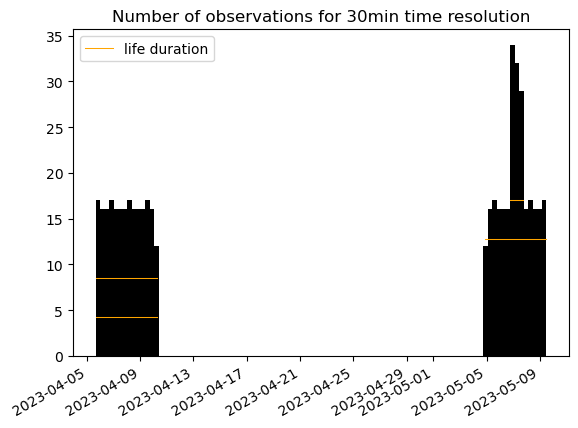

In [81]:
plot_time_histogram(files_30min, name='Number of observations for 30min time resolution')

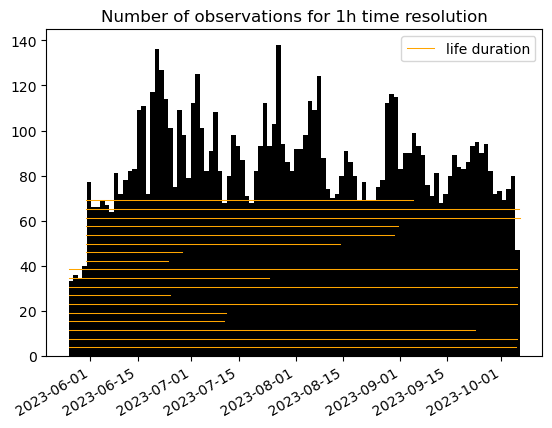

In [82]:
plot_time_histogram(files_1h, name='Number of observations for 1h time resolution')

## Trajectory with velocity graph

In [12]:
files = files_10min
ds = xr.open_dataset(os.path.join(L1_dir, files[1]))
files[1]

'L1_svp_ogs_20231005_140000_10min.nc'

In [22]:
### CHOOSE trajectory
id_idx = 0

    # all the trajectory
ds_traj_all = ds.isel(id=id_idx) 

    #only a part with inertial oscillations
time_slice_oscil = (1000, 2000)
ds_traj_oscil = ds.isel(id=id_idx).isel(time=slice(*time_slice_oscil))

In [23]:
def get_velocities_array(ds_traj, vector_spacing=30):
    time_vec = ds_traj.time.values[::vector_spacing]
    lat_vec  = ds_traj.lat.values[::vector_spacing]
    lon_vec  = ds_traj.lon.values[::vector_spacing]
    u_vec    = ds_traj.velocity_east.values[::vector_spacing]
    v_vec    = ds_traj.velocity_north.values[::vector_spacing]
    return time_vec, lat_vec, lon_vec, u_vec, v_vec

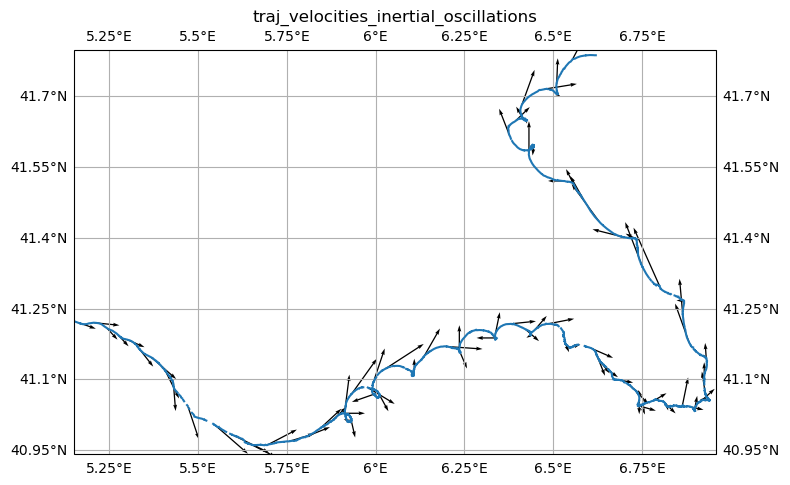

In [23]:
ds_traj = ds_traj_all
time_vec, lat_vec, lon_vec, u_vec, v_vec = get_velocities_array(ds_traj_all, vector_spacing = 30)
scale = 3e-5
width = 2e-3

# Plot the trajectory with the velocity vectors

fig = plt.figure(tight_layout=True, figsize=(8, 8))
crs = ccrs.PlateCarree()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
gl = ax.gridlines(draw_labels=True,)
ax.add_feature(cfeature.LAND,)

# trajectory
ax.plot(ds_traj.lon, ds_traj.lat,transform=crs)
# vectors
ax.quiver(lon_vec, lat_vec, u_vec, v_vec, angles='xy', scale_units='xy', scale=scale, width=width, transform=ccrs.PlateCarree())

plot_marge = 0.02
ax.set_extent([np.nanmin(lon_vec) - plot_marge, np.nanmax(lon_vec) + plot_marge, np.nanmin(lat_vec) - plot_marge, np.nanmax(lat_vec) + plot_marge], crs=ccrs.PlateCarree())

### SAVE
ax.set_title("traj_velocities_inertial_oscillations")
save_name = 'traj_velocities_inertial_oscillations.png'
plt.savefig(os.path.join(path_save_plot,save_name), bbox_inches='tight', dpi = 300)

#### focus on inertial oscillations

In [24]:
# vectors data
vector_spacing = 10
time_vec = ds_traj_oscil.time.values[::vector_spacing]
lat_vec  = ds_traj_oscil.lat.values[::vector_spacing]
lon_vec  = ds_traj_oscil.lon.values[::vector_spacing]
u_vec    = ds_traj_oscil.velocity_east.values[::vector_spacing]
v_vec    = ds_traj_oscil.velocity_north.values[::vector_spacing]

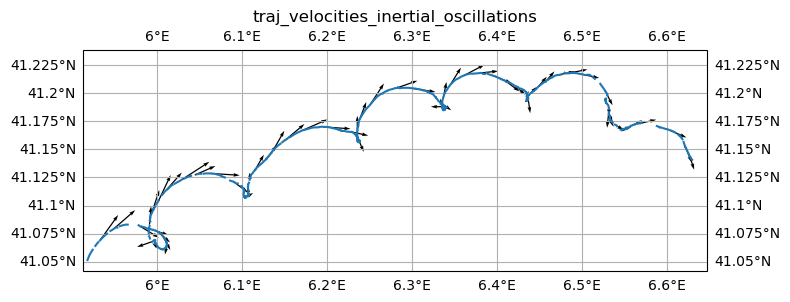

In [61]:
# Plot the trajectory with the velocity vectors

fig = plt.figure(tight_layout=True, figsize=(8, 8))
crs = ccrs.PlateCarree()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
gl = ax.gridlines(draw_labels=True,)
ax.add_feature(cfeature.LAND,)

# trajectory
ax.plot(ds_traj_oscil.lon, ds_traj_oscil.lat,transform=crs, label=str(id_idx_test))
# vectors
ax.quiver(lon_vec, lat_vec, u_vec, v_vec, angles='xy', scale_units='xy', scale=1e-4, width=2e-3, transform=ccrs.PlateCarree())

plot_marge = 0.02
ax.set_extent([np.nanmin(lon_vec) - plot_marge, np.nanmax(lon_vec) + plot_marge, np.nanmin(lat_vec) - plot_marge, np.nanmax(lat_vec) + plot_marge], crs=ccrs.PlateCarree())

### SAVE
ax.set_title("traj_velocities_inertial_oscillations")
save_name = 'traj_velocities_inertial_oscillations.png'
plt.savefig(os.path.join(path_save_plot,save_name), bbox_inches='tight', dpi = 300)

#### functions

In [ ]:
def _add_one_Tgrid_velocity(ds, u, axis, padding):
    u_t = jpw.tools.operators.interpolation(jnp.copy(ds[u].values), axis=axis, padding=padding)
    ds[str(u)+'_t'] = ds[u].copy(data=u_t)
    return ds

def add_Tgrid_velocities(ds):

    ds = _add_one_Tgrid_velocity(ds, 'u_geos', axis=1, padding='left')
    ds = _add_one_Tgrid_velocity(ds, 'v_geos', axis=0, padding='left')

    ds = _add_one_Tgrid_velocity(ds, 'u_var', axis=1, padding='left')
    ds = _add_one_Tgrid_velocity(ds, 'v_var', axis=0, padding='left')

    return ds


In [ ]:
def restrain_domain(ds, min_lon, max_lon, min_lat, max_lat):
    extend = (min_lon <= ds.longitude) & (ds.longitude <= max_lon) & (min_lat <= ds.latitude) & (ds.latitude <= max_lat)
    in_biscay = (ds.longitude <= -0.1462) & (ds.latitude >= 43.2744)
    in_blacksea = (ds.longitude >= 27.4437) & (ds.latitude >= 40.9088)
    
    mask = extend & ~(in_biscay | in_blacksea) # exclude biscay and black sea
    return ds.where(mask, drop=True)


def plot2d(lon, lat, data, bbox: tuple=bbox_mediterranea, cmap='Oranges', center_bar=False, fraction_cbar=0.033,  title= None, save_name=None):
    # Set up the figure and map projection
    fig = plt.figure(tight_layout=True, figsize=(8, 8))
    crs = ccrs.PlateCarree()
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
    _ = ax.gridlines(draw_labels=True,)

    # Add land feature for better visualization
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)

    # Set the map extent
    ax.set_extent(bbox, crs=crs)

    # Plot the density of points
    if center_bar:
        vmax = np.nanmax(np.abs(data))
        vmin = - vmax
    else:
        vmax = np.nanmax(data)
        vmin = np.nanmin(data)

    mesh = ax.pcolormesh(lon, lat, data, transform=crs, cmap=cmap, vmin=vmin, vmax=vmax)

    # Add a color bar to show the density scale
    cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', fraction=fraction_cbar, pad=0.08)
    #cbar.set_label('Density')


    if title:
        ax.set_title(title)
        
    ### SAVE
    if save_name:
        ax.set_title(save_name)
        save_name = save_name
        plt.savefig(os.path.join(path_save_plot,save_name), bbox_inches='tight', dpi = 300)

In [21]:
# MIOST field data

path = '/home/bouxdecl/Documents/my_python/MIOST/data_RESULTS/'
ds_nadir = xr.open_dataset(os.path.join(path, 'results_MIOST_allnadirs-alg_GOOD.nc'))
ds_swot = xr.open_dataset(os.path.join(path, 'results_MIOST_allnadirs-alg_and_SWOT_GOOD.nc'))

# add t-grid values for velocities

ds_nadir = add_Tgrid_velocities(ds_nadir)
ds_swot  = add_Tgrid_velocities(ds_swot)

## trajectory/fields comparison

In [17]:
def interp_velocity_fields(ds, time_vec, lat_vec, lon_vec):
    # x,y mapping on latitude, longitude is a regular grid
    new_y = np.interp(lat_vec, ds.latitude[:, 0], ds.y)
    new_x = np.interp(lon_vec, ds.longitude[0, :], ds.x)

    # interpolation on points of the trajectory
    ds_interp = ds.interp(time = time_vec, x=new_x, y=new_y)
    
    # extract velocities
    u_interp   = np.array([ds_interp.u_var_t[i, i, i] for i in range(time_vec.shape[0]) ])
    v_interp   = np.array([ds_interp.v_var_t[i, i, i] for i in range(time_vec.shape[0]) ])

    return u_interp, v_interp


def plot_velocities_drifters_fields_comparison(ds_field, ds_traj, time_vec, lat_vec, lon_vec, u_vec, v_vec, scale=1e-4, width=2e-3, save_name=None):
    
    u_field, v_field = interp_velocity_fields(ds_field, time_vec, lat_vec, lon_vec)
    
    # Plot the trajectory with the velocity vectors AND fields vectors

    fig = plt.figure(tight_layout=True, figsize=(8, 8))
    crs = ccrs.PlateCarree()
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
    gl = ax.gridlines(draw_labels=True,)
    ax.add_feature(cfeature.LAND,)

    # trajectory
    ax.plot(ds_traj.lon, ds_traj.lat,transform=crs, label='drifter trajectory')

    # drifters velocity
    ax.quiver(lon_vec, lat_vec, u_vec, v_vec, 
              
              color='black', angles='xy', scale_units='xy', scale=scale, width=width, transform=ccrs.PlateCarree(), label = 'drifters velocities')
    
    # field velocity
    ax.quiver(lon_vec, lat_vec, u_field, v_field,
              
              color='r', angles='xy', scale_units='xy', scale=scale, width=width, transform=ccrs.PlateCarree(), label='field velocities')


    plot_marge = 0.02
    ax.set_extent([np.nanmin(lon_vec) - plot_marge, np.nanmax(lon_vec) + plot_marge, np.nanmin(lat_vec) - plot_marge, np.nanmax(lat_vec) + plot_marge], crs=ccrs.PlateCarree())

    ax.legend()

    if save_name:
        ax.set_title(save_name)
        save_name = save_name + '.png'
        plt.savefig(os.path.join(path_save_plot, save_name), bbox_inches='tight', dpi = 300)

In [140]:
def _add_one_Tgrid_velocity(ds, u, axis, padding):
    u_t = jpw.tools.operators.interpolation(jnp.copy(ds[u].values), axis=axis, padding=padding)
    ds[str(u)+'_t'] = ds[u].copy(data=u_t)
    return ds

def add_Tgrid_velocities(ds):

    ds = _add_one_Tgrid_velocity(ds, 'u_geos', axis=1, padding='left')
    ds = _add_one_Tgrid_velocity(ds, 'v_geos', axis=0, padding='left')

    ds = _add_one_Tgrid_velocity(ds, 'u_var', axis=1, padding='left')
    ds = _add_one_Tgrid_velocity(ds, 'v_var', axis=0, padding='left')

    return ds


# MIOST field data

path = '/home/bouxdecl/Documents/my_python/MIOST/data_RESULTS/'
ds_nadir = xr.open_dataset(os.path.join(path, 'results_MIOST_allnadirs-alg_GOOD.nc'))
ds_swot = xr.open_dataset(os.path.join(path, 'results_MIOST_allnadirs-alg_and_SWOT_GOOD.nc'))

# add t-grid values for velocities

ds_nadir = add_Tgrid_velocities(ds_nadir)
ds_swot  = add_Tgrid_velocities(ds_swot)

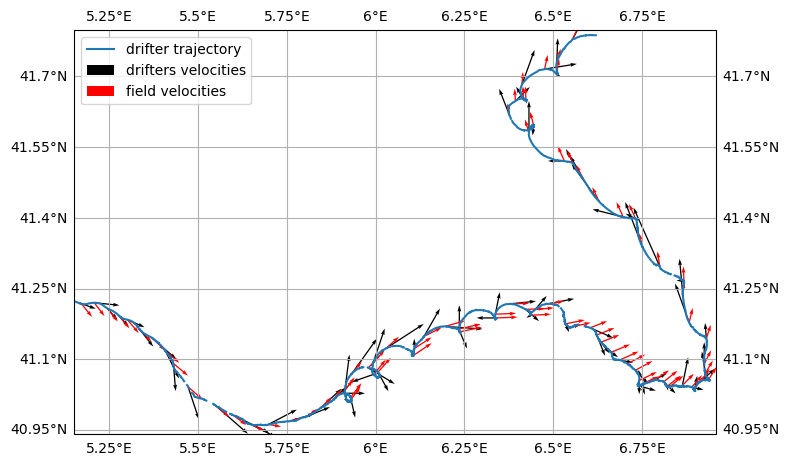

In [32]:
time_vec, lat_vec, lon_vec, u_vec, v_vec = get_velocities_array(ds_traj_all, vector_spacing = 30)

plot_velocities_drifters_fields_comparison(ds_nadir, ds_traj, time_vec, lat_vec, lon_vec, u_vec, v_vec, scale = 3e-5, width = 2e-3)

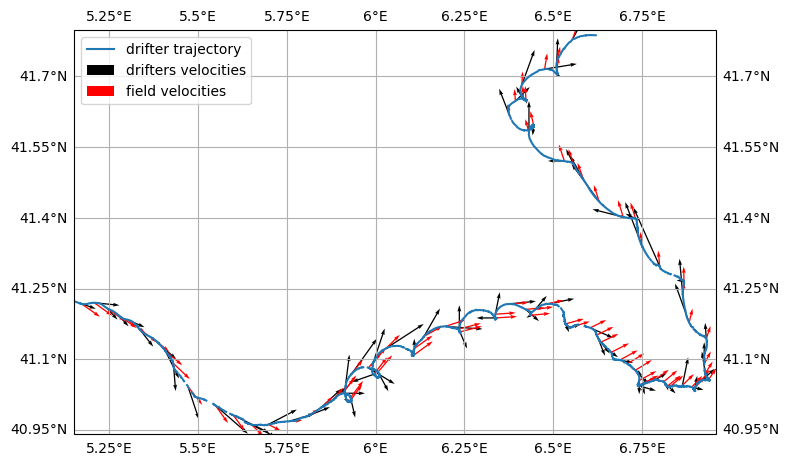

In [34]:
time_vec, lat_vec, lon_vec, u_vec, v_vec = get_velocities_array(ds_traj_all, vector_spacing = 30)

plot_velocities_drifters_fields_comparison(ds_swot, ds_traj, time_vec, lat_vec, lon_vec, u_vec, v_vec, scale = 3e-5, width = 2e-3)

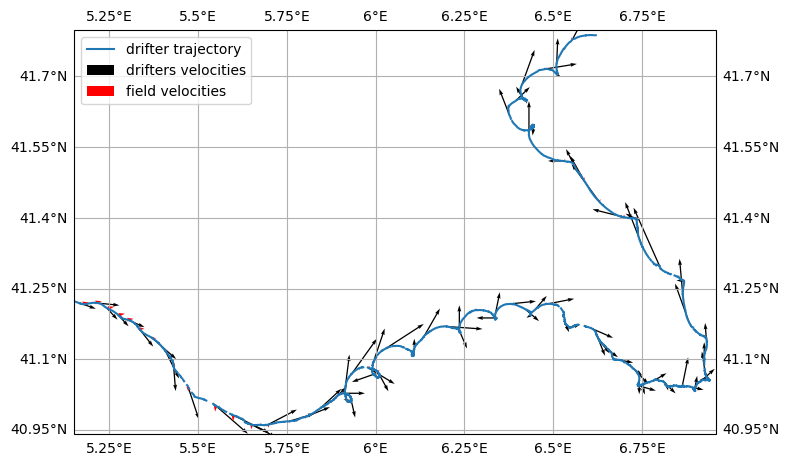

In [35]:
time_vec, lat_vec, lon_vec, u_vec, v_vec = get_velocities_array(ds_traj_all, vector_spacing = 30)

plot_velocities_drifters_fields_comparison(ds_swot-ds_nadir, ds_traj, time_vec, lat_vec, lon_vec, u_vec, v_vec, scale = 3e-5, width = 2e-3)